import all relevant modules

In [1]:
from Bio import SeqIO, AlignIO, Phylo
from Bio.SeqRecord import SeqRecord
import Bio.Align
from Bio.Align.AlignInfo import SummaryInfo
from Bio.Seq import Seq
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

import matplotlib
import matplotlib.pyplot as plt
from pymsaviz import MsaViz

import os
import time
import random 
import pandas as pd
import numpy as np 
import pytest
from functions import *

Setup the directory

In [2]:
#set up directories
dog_breeds = r"../data/dog_breeds.fa"
mystery_breed = r"../data/mystery.fa"
output = r"../results"
ind_breeds = r"../results/individual_breed_sequences"

In [3]:
#initialise the breed class with dog breeds data 
initialise_Breed()
#use the breed_sequences function to create fasta file with all sequenes belonging to the same breed
#these are stored in the individual_breed_sequences folder of the results folder
breed_sequences()
#store consensus sequences in a results folder in a file called consensus_sequences
create_output(consensus_file(), f"{output}/consensus_sequences", "fasta" )
#create output with the mystery sequence
create_output(add_mystery_to_consensus(), f"{output}/consensus_sequences_with_mystery", "fasta" )
#hold the list as a value for easy acess later on 
consensus_sequences_with_unknown = add_mystery_to_consensus()

Create a class to store consensus sequences 

In [4]:
#get consensus sequences
consensus_file = f"{output}/consensus_sequences"
consensus_sequences = read_fasta(consensus_file)
#get mystery sequences
mystery_sequence = read_fasta(mystery_breed)
#initialise the Breed_consensus class with all the breed_consesnus files
initialise_Breed_consensus(consensus_file)

Find the top alignment and store it in a file (this function is the one which takes the longest)

In [5]:
#align_consensus sequences with the mystery sequence
top_alignment_details = align_consensus(consensus_sequences, mystery_sequence[0])
top_alignment = top_alignment_details[1][0]

#create a directory for the top alignment file 
filename = f"{output}/top_alignment_output"  
#create a file to store the top scoring alignment as clustal file 
with open(filename, "w"):
        Bio.Align.write(top_alignment, filename, "clustal")

#calculate percentage similarity of the top scoring sequence 
top_percentage = percentage_similarity(top_alignment)

#get results aka the breed, its sequence and percentage similarity 
results = "The breed most similar to the mystery DNA file is the", top_alignment_details[2], " its percent identity is ", top_percentage, "%" ," the alignment of the mystery dog breed and", top_alignment_details[2], "is displayed here: \n", top_alignment

#create a string representing thr results that can be written to the results file 
results_str = str()
for key in results:
    results_str += str(key) 

#create a directory and filename for the details of the top alignment
filename2 = f"{output}/top_alignment_details"  
#create a file to store details about the  top alignment as a txt file 
with open(filename2, "w") as file:
        file.write(results_str)

#create a graph for each 100 bases long sequence alignment figure 

read_alignment = AlignIO.read(f"{output}/top_alignment_output", "clustal")  

l = len(top_alignment[0]) 
mv = MsaViz(read_alignment, format="clustal", start=1, end=l, wrap_length=100, show_consensus = True)
mv.savefig(f"{output}/top_alignment_image")

16705.0 <Bio.Align.PairwiseAlignments object at 0x0000022101157830> ENGLISH_SPRINGER_SPANIEL 


Create a phylogenic tree describing the relationship between the breeds 

In [6]:
#define filepath for the fasta file storing all sequences
consesnsus_with_mystery = f"{output}/consensus_sequences_with_mystery"
#create a MSA from the sequences in consesnsus_with_mystery file
MSA_alignment_result = MSA_alignment(consesnsus_with_mystery)

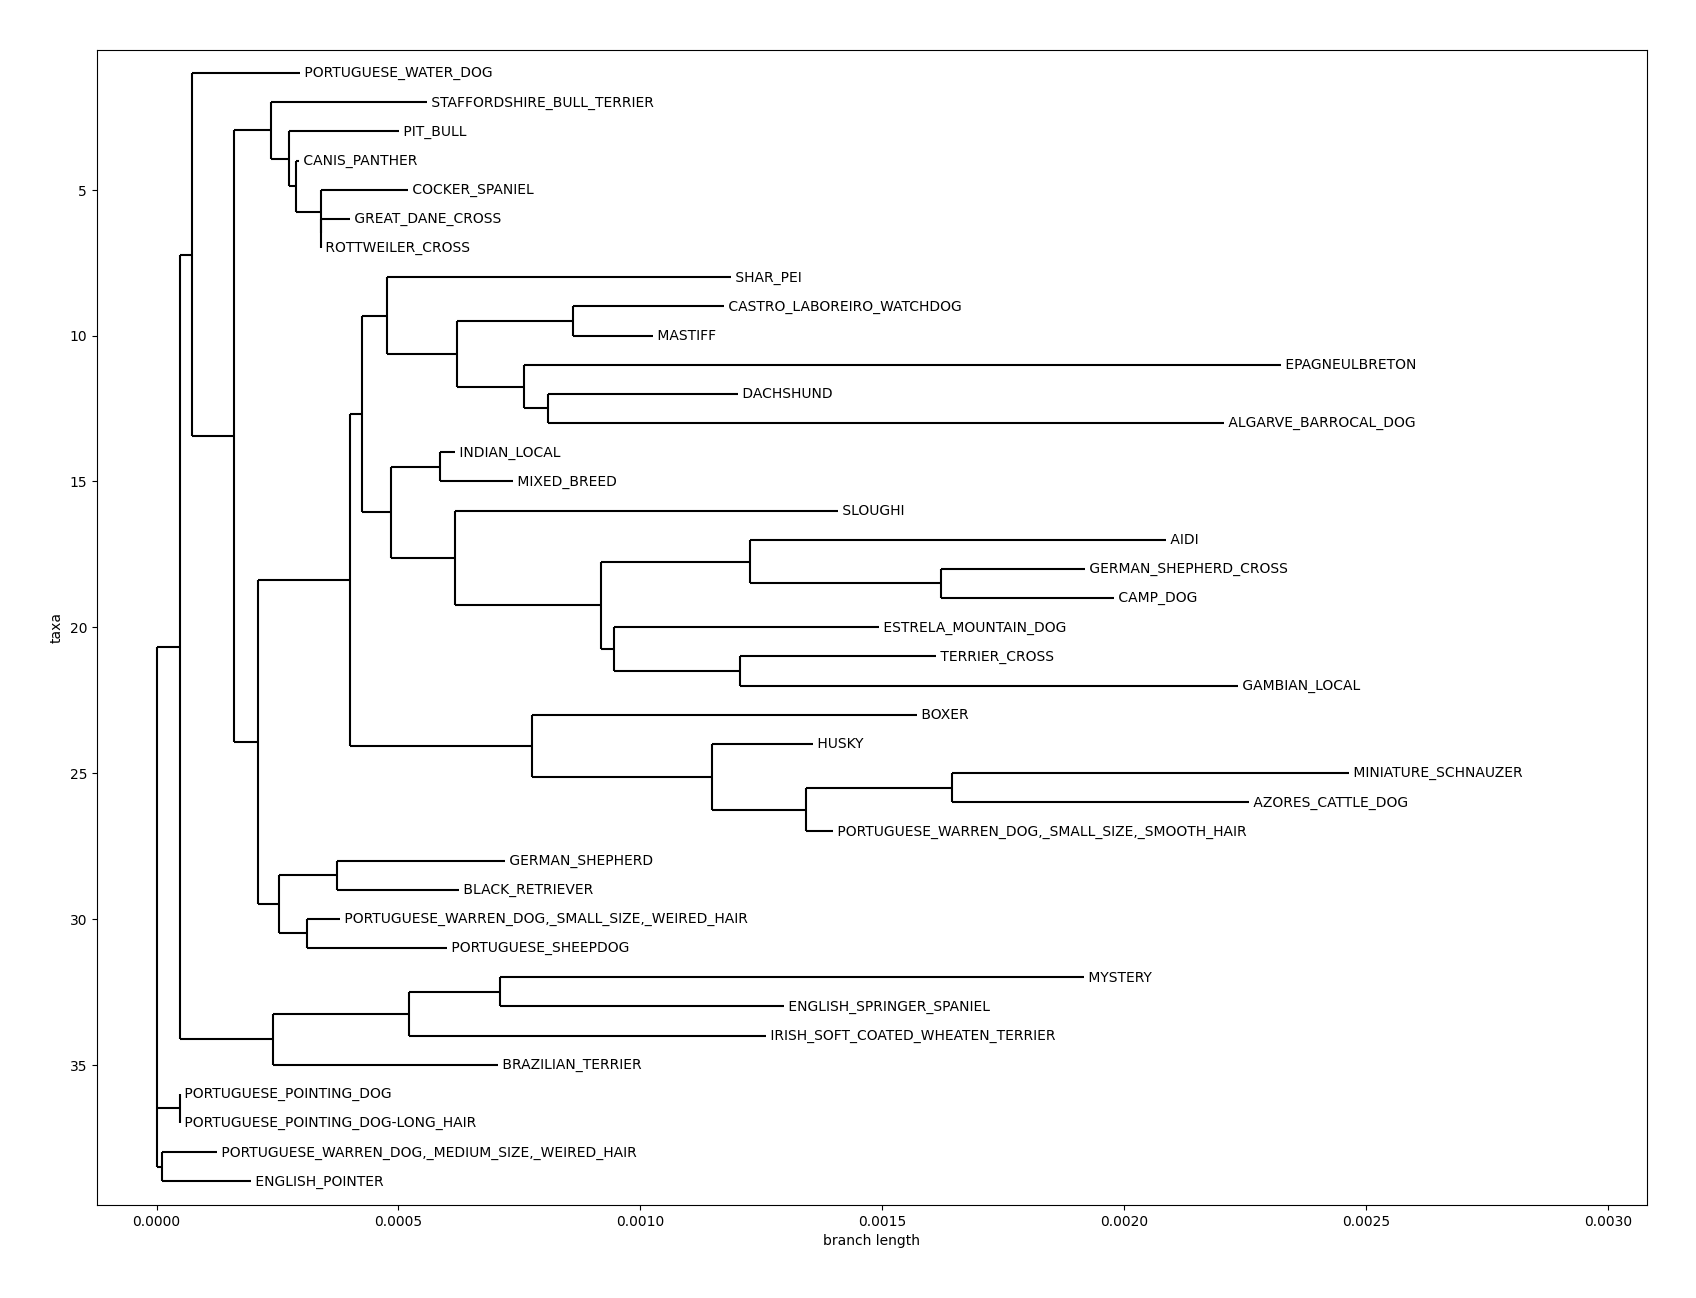

In [7]:
#build a phylogentic tree as a phyloxml file
build_phylo_tree(MSA_alignment_result)

#access the file where the nexus format tree is and save it in a variable 
breeds_xml = Phylo.read(f"{output}/breeds_tree.xml", "phyloxml")
    
#plot the tree 
fig = plt.figure(figsize=(20,15), dpi=100, frameon=True)
ax = plt.gca()
Phylo.draw(breeds_xml, show_confidence=True, axes=ax, label_func=custom_label_func)
fig.savefig(f"{output}/Phylogenetic_tree")


Probability 

In [8]:
#set the sequence length to mirror the real database
seq_len = 16729
#set the size of the database to mirror the real one 
database_size = 100

#generate a list of the base proportions to use in DNA generation
proportion = base_content(mystery_sequence[0])
print(proportion)

#store the sequences generated in a variable     
sequences = random_sequences(database_size, seq_len, proportion)


[14, 25, 28, 31]


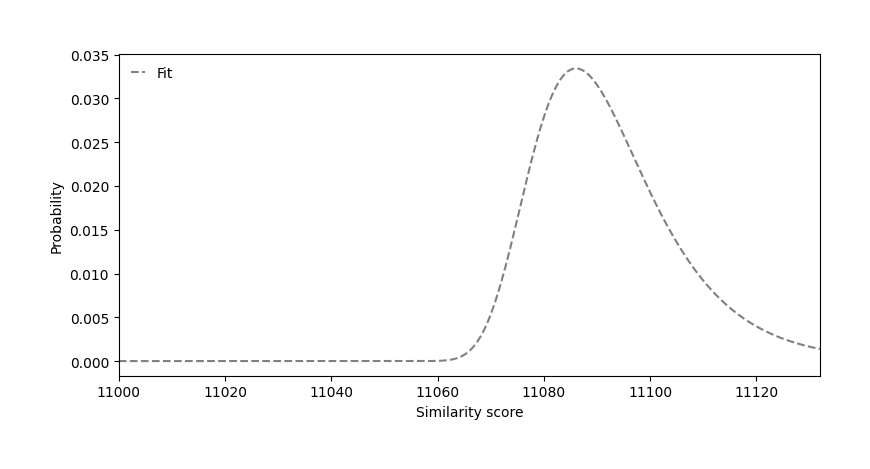

In [9]:


#store the alignment scores of the random sequences in a variable 
random_scores = alignment_scores(random_DNA(seq_len, proportion), sequences)

# Score frequencies of random sequence alignment scores
freqs = np.bincount(random_scores) / database_size

# Use method of moments to estimate distribution parameters
l = np.pi / np.sqrt(6 * np.var(random_scores))
u = np.mean(random_scores) - np.euler_gamma / l

# Coordinates for the fit
x = np.linspace(11000, len(freqs)-1, 500)
y = pdf(x, l, u)

#plot the probability graph 
fig, ax = plt.subplots(figsize=(8.0, 4.0))
ax.plot(x, y, color="gray", linestyle="--", label="Fit")
ax.set_xlabel("Similarity score")
ax.set_ylabel("Probability")
ax.set_xlim(11000, len(freqs)-1)
ax.legend(loc="upper left")
fig.tight_layout()
fig.savefig(f"{output}/probability_distribution")

In [10]:
#claculate alignment scores in the real database
breed_scores = breed_alignment_scores(random_DNA(seq_len, proportion))

In [11]:
#create a dataframe to strore the proability of the alignment with each breed consensus occuring by chance

probability_df(breed_scores.keys(), breed_scores.values(), l, u)

,breed,probability
3,GAMBIAN_LOCAL,3.115206e-37
33,EPAGNEULBRETON,3.115206e-37
1,ALGARVE_BARROCAL_DOG,5.027728e-34
12,TERRIER_CROSS,4.239349e-31
15,CAMP_DOG,5.358980e-26
17,SLOUGHI,8.865609e-24
25,AIDI,8.865609e-24
35,GERMAN_SHEPHERD_CROSS,8.865609e-24
32,ESTRELA_MOUNTAIN_DOG,8.865609e-24
34,DACHSHUND,8.865609e-24
